# Multi-Distance Phase-Contrast Simulation

In this notebook, the term phase image is used interchangeably with the term delta projections.
Similarly, the term absorption image is used interchangeably with the term beta projections.
The phase and absorption images are obtained by multiplying the delta and beta projections by the wavenumber.

Dimensionality, measurement, and reconstruction parameters for simulation. 

In [1]:
# Dimensionality along the y-axis (vertical axis) and x-axis (horizontal axis)
N_y, N_x = 128, 128
# Pixel width in mm units. Also, popularly known as pixel size.
pix_width = 0.00065
# X-ray energy (in keV)
energy = 20
# Propagation distances (object-to-detector distance for parallel-beam X-rays)
prop_dists = [10, 100, 200]
# Ground-truth refractive index decrement (delta) and absorption index (beta).
# Use https://henke.lbl.gov/optical_constants/getdb2.html
# Refractive index decrements for SiC, Teflon (C2F4), Al2O3, Polyimide (C22H10N2O5).
delta_gt = [1.67106361e-6, 1.09720611e-6, 2.02572255e-6, 7.61298395e-7]
# Absorption indices for SiC, Teflon (C2F4), Al2O3, Polyimide (C22H10N2O5).
beta_gt = [4.77064388e-9, 9.08938758e-10, 3.97340827e-9, 3.21013771e-10]
# Radii (in mm) of spheres for simulation.
width_x, width_y = N_x*pix_width, N_y*pix_width
radii = [width_x/6, width_x/4, width_x/6, width_x/4]
center_y = [width_y/2-width_y/8, width_y/2, width_y/2+width_y/8, width_y/2]
center_x = [width_x/2-width_x/8, width_x/2, width_x/2+width_x/8, width_x/2]
# Percentage of Possion-like noise. Percentage is with respect to the mean of the X-ray transmission value.
noise_perc = 0.1
# Number of parallel processes. For GPU compute, please do not exceed the total number of GPUs.
processes = 1
# Choice of device for compute. For GPU compute, please specify as "cuda". For CPU, specify as "cpu".
device = "cpu"
# Simulate at 8 times the resolution to avoid inverse crime.
sim_upsmpl = 8
# Shape at higher resolution.
N_y_upsmpl, N_x_upsmpl = N_y*sim_upsmpl, N_x*sim_upsmpl
# Pixel width at higher resolution.
pix_width_upsmpl = pix_width/sim_upsmpl
# Keyword arguments for the LBFGS solver used in NLPR. For more information, see help for the NLPR functions.
# While we do provide suitable defaults, we recommened the user to learn to set these parameters.
# These parameters may need to be tweaked to reduce run-time. 
# If not specified explicitly for NLPR, the default parameters are probably unncessarily strict.
solver_kwargs = {'solver': 'non-native', # Use a custom LBFGS solver that is not implemented within pytorch.
                 'history_size': 64, # History size for Hessian computation. Higher number increases memory usage.  
                 'max_iter': 1e3, # Maximum number of iterations. Recommended to cap it at 1e4 (slower run-time) or 1e3 (faster run-time).
                 'line_search_fn': 'Wolfe', # Uses "Wolfe" line-search during optimization.
                 'rec_thresh': 0.5, # Convergence threshold for change in reconstruction values.
                 'rec_convg': True, # Use reconstruction values to measure convergence. 
                 'cost_thresh': 1.0, # Convergence threshold for change in cost (objective function) value. 
                 'cost_convg': False, # Do not use cost (objective function) values to measure convergence. 
                 'chk_iters': 5} # Stop LBFGS after 5 consecutive iterations where changes in both reconstruction and cost are below their respective thresholds.
# cost_thresh is not used since cost_convg is False.
# Set cost_convg to True if the NLPR result does not significantly differ from the initialized value, which indicates insufficient convergence.
# cost_convg is set to True by default.

Import python packages.

In [2]:
import numpy as np # For numerical operations
import matplotlib.pyplot as plt # For image visualization
from phasetorch.mono.sim import simdata # For phase-contrast simulation
from phasetorch.util import path_lengths_sphere # For computing ground-truth projections
from skimage.transform import downscale_local_mean # For down-sampling projections and X-ray images
from skimage.metrics import normalized_root_mse # For quantitative analysis of phase-retrieved images
from skimage.morphology import binary_erosion # For eroding the mask used during background subtraction

Simulation of X-ray transmission images. X-ray transmission is nominally scaled between 0 and 1. The transmission value may exceed these bounds in the presence of phase-contrast. To avoid inverse crime, we perform simulations at a much higher resolution than the resolution used for phase-retrieval. We downsample the measurement data at the detector.

In [3]:
# Initialize the projections of delta and beta to zeros.
delta_projs_gt = np.zeros((N_y_upsmpl, N_x_upsmpl), dtype=np.float32)
beta_projs_gt = np.zeros((N_y_upsmpl, N_x_upsmpl), dtype=np.float32)

# Mask denotes the region with non-zero projection values. It is used later for background subtraction.
mask_projs_gt = np.zeros((N_y_upsmpl, N_x_upsmpl), dtype=np.float32)

# Total projection is the sum of projections through all the spheres.
# We assume that the spheres are non-overlapping along the X-ray propagation axis.
for dl, bt, cy, cx, rd in zip(delta_gt, beta_gt, center_y, center_x, radii):
    path, mask = path_lengths_sphere(N_y_upsmpl, N_x_upsmpl, pix_width_upsmpl, cy, cx, rd)
    delta_projs_gt += dl*path
    beta_projs_gt += bt*path
    mask_projs_gt += mask

# Add one unitary dimension to indicate one view. "gt" indicates ground-truth.
delta_projs_gt, beta_projs_gt = delta_projs_gt[np.newaxis], beta_projs_gt[np.newaxis]

# Simulation of X-ray transmission images.
if __name__ == "__main__": # May be necessary for multiprocessing support 
    rads = simdata(delta_projs_gt, beta_projs_gt, pix_width_upsmpl, energy, prop_dists, processes=processes, device=device)

# Simulate Poisson-type noise in transmission space.
rads += 0.01*noise_perc*np.sqrt(rads)*np.random.randn(*rads.shape)

# Downsample the X-ray images.
rads = downscale_local_mean(rads, factors=(1, 1, sim_upsmpl, sim_upsmpl))

# Downsample the projections for comparison with phase-retrieved images.
delta_projs_gt = downscale_local_mean(delta_projs_gt, factors=(1, sim_upsmpl, sim_upsmpl))
beta_projs_gt = downscale_local_mean(beta_projs_gt, factors=(1, sim_upsmpl, sim_upsmpl))

# Downsample the mask.
mask = downscale_local_mean(mask_projs_gt, factors=(sim_upsmpl, sim_upsmpl))
mask = mask > 0


Dists is [ 10. 100. 200.]
Running 1 process instances from 0
Multi-processing: Progress = 100.0 %


Visualize X-ray transmission images.

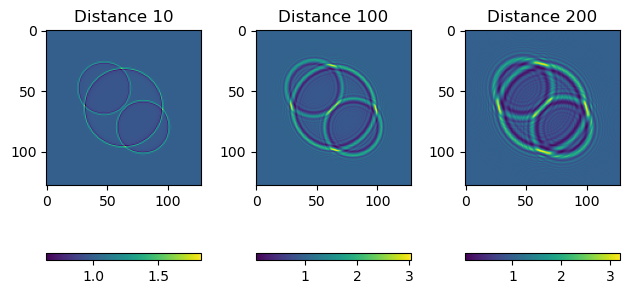

In [4]:
# Create a matplotlib subplot.
fig, axs = plt.subplots(nrows=1, ncols=3)

# X-ray image at the first propagation distance.
im = axs[0].imshow(rads[0,0])
axs[0].set_title("Distance {}".format(prop_dists[0]))
fig.colorbar(im, ax=axs[0], orientation="horizontal")

# X-ray image at the 2nd propagation distance.
im = axs[1].imshow(rads[0,1])
axs[1].set_title("Distance {}".format(prop_dists[1]))
fig.colorbar(im, ax=axs[1], orientation="horizontal")

# X-ray image at the 3rd propagation distance.
im = axs[2].imshow(rads[0,2])
axs[2].set_title("Distance {}".format(prop_dists[2]))
fig.colorbar(im, ax=axs[2], orientation="horizontal")

plt.tight_layout()
plt.show()

# Multi-Distance Phase-Retrieval

Import functions for multi-distance phase-retrieval.

In [5]:
from phasetorch.mono.pr import ctf, tie, mixed, nlpr

Contrast Transfer Function (CTF) phase-retrieval of delta projections. CTF has a regularization parameter that may need to be tuned for optimal performance. As a good initial guess, we recommend setting the ``rel_regp`` parameter to a small value such as ``1e-8``.

In [6]:
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_ctf, beta_projs_ctf = ctf(rads, pix_width, energy, prop_dists, rel_regp=10**-8, 
                                          processes=processes, device=device)

Dists is [ 10. 100. 200.]
Running 1 process instances from 0
reg_par is 4.4939252319409206e-08 when rel_reg_par is 1e-08
Multi-processing: Progress = 100.0 %


Transport of Intensity Equation (TIE) phase-retrieval using data at the first two propagation distances. TIE also has a regularization parameter that may need to be tuned for optimal performance. As a good initial guess, we recommend setting the ``rel_regp`` parameter to a small value such as ``1e-8``.

In [7]:
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_tie, beta_projs_tie = tie(rads[:, :2], pix_width, energy, prop_dists[:2], 
                                          rel_regp=10**-8, processes=processes, device=device)

Dists is [ 10. 100.]
Running 1 process instances from 0
reg_par is 0.011834319526627217 when rel_reg_par is 1e-08
Multi-processing: Progress = 100.0 %


Non-linear phase-retrieval (NLPR) for reconstruction of projections of delta and beta. Here, NLPR is initialized with CTF phase-retrieval. Any phase-retrieval algorithm (either multi or single distance) can provide initial estimates for NLPR. Even zero initialization for the projections of delta and beta is valid. 

In [8]:
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_nlpr_ctfinit, beta_projs_nlpr_ctfinit = nlpr(rads, pix_width, energy, prop_dists, delta_projs_ctf, 
                            beta_projs=beta_projs_ctf, processes=processes, device=device, solver_kwargs=solver_kwargs) 

processes=1, device=cpu, dtype=float
pix_wid=0.00065, energy=20, prop_dists=[10, 100, 200]
Dists is [ 10. 100. 200.]
Running 1 process instances from 0
LBFGS: {'solver': 'non-native', 'history_size': 64, 'max_iter': 1000.0, 'line_search_fn': 'Wolfe', 'rec_thresh': 0.5, 'rec_convg': True, 'cost_thresh': 1.0, 'cost_convg': False, 'chk_iters': 5}
Optimized parameters are ['rec']
Initial loss: 2.69e-02
Total iters is 93 and max line search iters is 20
Total closure evals is 119 and total grad evals is 118
Perc change in reconstruction is 1.58e-01
Perc change in loss is 3.84e-01
Final loss: 4.71e-05
Multi-processing: Progress = 100.0 %


NLPR that is initialized using TIE phase-retrieved images.

In [9]:
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_nlpr_tieinit, beta_projs_nlpr_tieinit = nlpr(rads, pix_width, energy, prop_dists, delta_projs_tie, 
                            beta_projs=beta_projs_tie, processes=processes, device=device, solver_kwargs=solver_kwargs) 

processes=1, device=cpu, dtype=float
pix_wid=0.00065, energy=20, prop_dists=[10, 100, 200]
Dists is [ 10. 100. 200.]
Running 1 process instances from 0
Multi-processing: Progress = 100.0 %


Visualize the projections of refractive index decrement (delta) using various phase-retrieval algorithms.

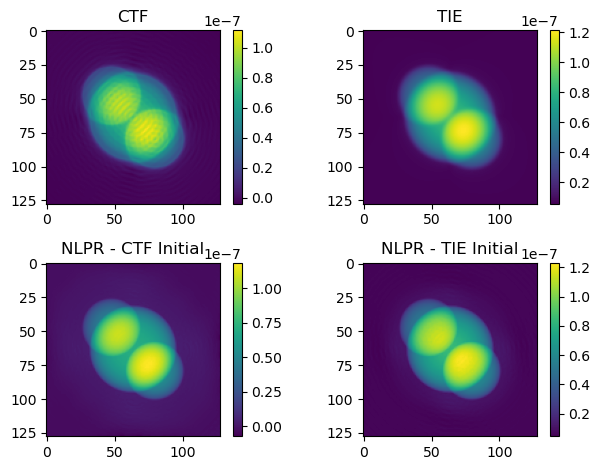

In [10]:
# Create a matplotlib subplot.
fig, axs = plt.subplots(nrows=2, ncols=2)

# Delta projection image using CTF.
im = axs[0, 0].imshow(delta_projs_ctf[0])
axs[0, 0].set_title("CTF")
fig.colorbar(im, ax=axs[0,0])

# Delta projection image using TIE
im = axs[0, 1].imshow(delta_projs_tie[0])
axs[0, 1].set_title("TIE")
fig.colorbar(im, ax=axs[0,1])

# Delta projection image using NLPR that is initialized with CTF
im = axs[1, 0].imshow(delta_projs_nlpr_ctfinit[0])
axs[1, 0].set_title("NLPR - CTF Initial")
fig.colorbar(im, ax=axs[1,0])

# Delta projection image using NLPR that is initialized with TIE
im = axs[1, 1].imshow(delta_projs_nlpr_tieinit[0])
axs[1, 1].set_title("NLPR - TIE Initial")
fig.colorbar(im, ax=axs[1,1])

plt.tight_layout()
plt.show()

Functions to convert from images of delta/beta projections to phase/absorption.

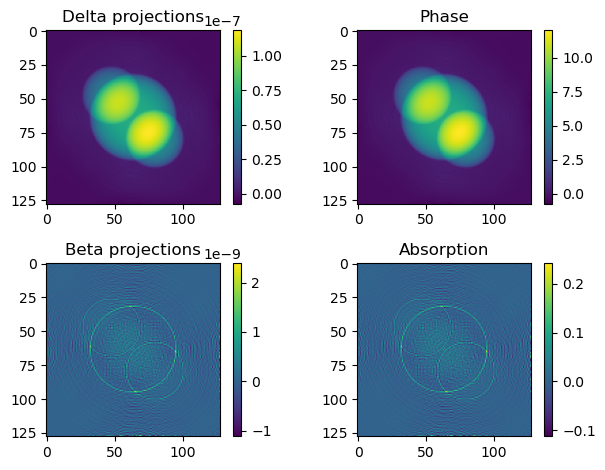

In [11]:
# Use function ``cproj_cphase()`` to convert from delta projections to phase values.
# Use function ``cphase_cproj()`` to convert from phase values to delta projections.
from phasetorch.util import cproj_cphase

phase_nlpr_ctfinit = cproj_cphase(delta_projs_nlpr_ctfinit, energy=energy)
absorp_nlpr_ctfinit = cproj_cphase(beta_projs_nlpr_ctfinit, energy=energy)

# Create a matplotlib subplot.
fig, axs = plt.subplots(nrows=2, ncols=2)

# Delta projection image.
im = axs[0, 0].imshow(delta_projs_nlpr_ctfinit[0])
axs[0, 0].set_title("Delta projections")
fig.colorbar(im, ax=axs[0,0])

# Phase image.
im = axs[0, 1].imshow(phase_nlpr_ctfinit[0])
axs[0, 1].set_title("Phase")
fig.colorbar(im, ax=axs[0,1])

# Beta projection image.
im = axs[1, 0].imshow(beta_projs_nlpr_ctfinit[0])
axs[1, 0].set_title("Beta projections")
fig.colorbar(im, ax=axs[1,0])

# Absorption image.
im = axs[1, 1].imshow(absorp_nlpr_ctfinit[0])
axs[1, 1].set_title("Absorption")
fig.colorbar(im, ax=axs[1,1])

plt.tight_layout()
plt.show()

Quantitative evaluation of delta projections using normalized root mean square error (NRMSE).

In [12]:
print("Normalized Root Mean Squared Error (NRMSE)")
print("CTF: ", normalized_root_mse(delta_projs_gt, delta_projs_ctf))
print("TIE: ", normalized_root_mse(delta_projs_gt, delta_projs_tie))
print("NLPR - CTF Initial: ", normalized_root_mse(delta_projs_gt, delta_projs_nlpr_ctfinit))
print("NLPR - TIE Initial: ", normalized_root_mse(delta_projs_gt, delta_projs_nlpr_tieinit))

Normalized Root Mean Squared Error (NRMSE)
CTF:  0.16484193368256558
TIE:  0.2192992988458489
NLPR - CTF Initial:  0.06316715892610042
NLPR - TIE Initial:  0.20504011241642617


Here, we perform background subtraction for improved quantitative accuracy. Since the average value of delta projections is lost during phase-retrieval, background subtraction may help improve accuracy. Hence, we compute the NRMSE after subtracting the values in the background regions. 

In [13]:
# Create mask for the background region.
mask_bg = np.bitwise_not(mask)
# Remove the region that are close to the image edges.
mask_bg = binary_erosion(mask_bg, footprint=np.ones((32, 32))) 

# plt.imshow(mask_bg)
# plt.show()

delta_projs_ctf_bg = delta_projs_ctf - np.mean(delta_projs_ctf[0][mask_bg])
delta_projs_tie_bg = delta_projs_tie - np.mean(delta_projs_tie[0][mask_bg])
delta_projs_nlpr_ctfinit_bg = delta_projs_nlpr_ctfinit - np.mean(delta_projs_nlpr_ctfinit[0][mask_bg])
delta_projs_nlpr_tieinit_bg = delta_projs_nlpr_tieinit - np.mean(delta_projs_nlpr_tieinit[0][mask_bg])

print("NRMSE after background subtraction") 
print("CTF : ", normalized_root_mse(delta_projs_gt, delta_projs_ctf_bg))
print("TIE : ", normalized_root_mse(delta_projs_gt, delta_projs_tie_bg))
print("NLPR - CTF Initial: ", normalized_root_mse(delta_projs_gt, delta_projs_nlpr_ctfinit_bg))
print("NLPR - TIE Initial: ", normalized_root_mse(delta_projs_gt, delta_projs_nlpr_tieinit_bg))

NRMSE after background subtraction
CTF :  0.1686001678231754
TIE :  0.10095869470854131
NLPR - CTF Initial:  0.07661668967554054
NLPR - TIE Initial:  0.06250391924750127


# Single-Distance Phase-Contrast Simulation

Simulate X-ray transmission images at a single propagation distance. Below, we only set the delta, beta, and propagation distance parameters. Most of the simulation parameters were set in the beginning of this notebook. Hence, please scroll to the top of this notebook to obtain the values for the other parameters.

In [14]:
# Simulate 2 spheres of SiC and Al2O3.
# Refractive index decrements for SiC and Al2O3.
delta_gt = [1.67106361e-6, 1.67106361e-6]
# Absorption indices for SiC and Al2O3.
beta_gt = [4.77064388e-9, 4.77064388e-9]
# Radii (in mm) of spheres for simulation.
width_x, width_y = N_x*pix_width, N_y*pix_width
radii = [width_x/6, width_x/6]
center_y = [width_y/2-width_y/8, width_y/2+width_y/8]
center_x = [width_x/2-width_x/8, width_x/2+width_x/8]

# Propagation distance (For parallel-beam, this is the object to detector distance).
prop_dist = 100

# Initialize the delta and beta projections to zeros.
delta_projs_gt = np.zeros((N_y_upsmpl, N_x_upsmpl), dtype=np.float32)
beta_projs_gt = np.zeros((N_y_upsmpl, N_x_upsmpl), dtype=np.float32)

# Total projection is the sum of projections through all the spheres.
# We assume that the spheres are non-overlapping along the X-ray propagation axis.
for dl, bt, cy, cx, rd in zip(delta_gt, beta_gt, center_y, center_x, radii):
    path, _ = path_lengths_sphere(N_y_upsmpl, N_x_upsmpl, pix_width_upsmpl, cy, cx, rd)
    delta_projs_gt += dl*path
    beta_projs_gt += bt*path

# Add one unitary dimension to indicate one view.
delta_projs_gt, beta_projs_gt = delta_projs_gt[np.newaxis], beta_projs_gt[np.newaxis]

# Simulation of X-ray transmission images. "gt" indicates ground-truth.
if __name__ == "__main__": # May be necessary for multiprocessing support 
    rads = simdata(delta_projs_gt, beta_projs_gt, pix_width_upsmpl, energy, prop_dist, processes=processes, device=device)

# Simulate Poisson-type noise in transmission space.
rads += 0.01*noise_perc*np.sqrt(rads)*np.random.randn(*rads.shape)

# Downsample the X-ray images.
rads = downscale_local_mean(rads, factors=(1, 1, sim_upsmpl, sim_upsmpl))

# Remove the unitary dimension for the propagation distances.
# Note: The redundant operations of adding/removing unitary dimensions stress the importance of dimensionalities. 
rads = np.squeeze(rads, axis=0)

# Downsample the ground-truth projections for comparison with phase-retrieved images.
delta_projs_gt = downscale_local_mean(delta_projs_gt, factors=(1, sim_upsmpl, sim_upsmpl))
beta_projs_gt = downscale_local_mean(beta_projs_gt, factors=(1, sim_upsmpl, sim_upsmpl))

Dists is [100.]
Running 1 process instances from 0
Multi-processing: Progress = 100.0 %


# Single-Distance Phase-Retrieval

Import functions for performing single-distance phase-retrieval.

In [15]:
from phasetorch.mono.pr import paganin, nlprcon

Perform Paganin phase-retrieval using an X-ray image at a single propagation distance.

In [16]:
delta_over_beta = np.mean(np.array(delta_gt))/np.mean(np.array(beta_gt))
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_pag = paganin(rads, pix_width, energy, 
                              prop_dist, delta_over_beta, processes=processes, device=device)

Running 1 process instances from 0
Multi-processing: Progress = 100.0 %


Perform single-distance non-linear phase-retrieval while also constraining the phase (or projections of delta) to be proportional to the absorption (or projections of beta). This constraint also forces the delta to be proportional to beta. 

One approach to imposing the proportionality constraint between ``delta`` and ``beta`` is to set ``alpha=1`` and ``gamma=delta/beta``. This approach may lead to numerical instabilities for large values of ``delta``. 

In [17]:
alpha, gamma = 1.0, delta_over_beta
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_nlprcon_alpha1, _ = nlprcon(rads, pix_width, energy, prop_dist, 
                                                  delta_projs=delta_projs_pag, alpha=alpha, gamma=gamma, 
                                                  processes=processes, device=device, solver_kwargs=solver_kwargs)

processes=1, device=cpu, dtype=float
pix_wid=0.00065, energy=20, prop_dists=100
Dists is [100.]
Running 1 process instances from 0
LBFGS: {'solver': 'non-native', 'history_size': 64, 'max_iter': 1000.0, 'line_search_fn': 'Wolfe', 'rec_thresh': 0.5, 'rec_convg': True, 'cost_thresh': 1.0, 'cost_convg': False, 'chk_iters': 5}
Optimized parameters are ['rec']
Initial loss: 3.31e-03
Total iters is 28 and max line search iters is 10
Total closure evals is 30 and total grad evals is 28
Perc change in reconstruction is 4.14e-01
Perc change in loss is 9.33e+00
Final loss: 2.28e-06
Multi-processing: Progress = 100.0 %


WARNING: The following approach to setting of ``alpha`` and ``gamma`` is experimental and needs more investigation.
An alternate approach to imposing the proportionality constraint between delta and beta is to use the function ``phasetorch.mono.pr.tropt_nlprcon``. This function computes the ``alpha`` and ``gamma`` to avoid several sources of numerical instabilities. However, it requires knowledge of both ``delta`` and ``beta``.

In [18]:
from phasetorch.mono.pr import tropt_nlprcon
alpha, gamma = tropt_nlprcon(np.mean(np.array(delta_gt)), np.mean(np.array(beta_gt)), N_x, pix_width, energy)
if __name__ == "__main__": # May be necessary for multiprocessing support 
    delta_projs_nlprcon_tropt, _ = nlprcon(rads, pix_width, energy, prop_dist, 
                                                  delta_projs=delta_projs_pag, alpha=alpha, gamma=gamma, 
                                                  processes=processes, device=device, solver_kwargs=solver_kwargs)

processes=1, device=cpu, dtype=float
pix_wid=0.00065, energy=20, prop_dists=100
Dists is [100.]
Running 1 process instances from 0
LBFGS: {'solver': 'non-native', 'history_size': 64, 'max_iter': 1000.0, 'line_search_fn': 'Wolfe', 'rec_thresh': 0.5, 'rec_convg': True, 'cost_thresh': 1.0, 'cost_convg': False, 'chk_iters': 5}
Optimized parameters are ['rec']
Initial loss: 3.31e-03
Total iters is 24 and max line search iters is 10
Total closure evals is 30 and total grad evals is 29
Perc change in reconstruction is 4.24e-01
Perc change in loss is 7.16e+00
Final loss: 3.33e-05
Multi-processing: Progress = 100.0 %


Visualize the phase-retrieved projections of delta. Single-distance NLPR with constraints may enhance the noise. This noise may increase the dynamic range and lead to minimum/maximum values that are sub-optimal for visualization. Hence, we manually set the minimum and maximum values during visualization. 

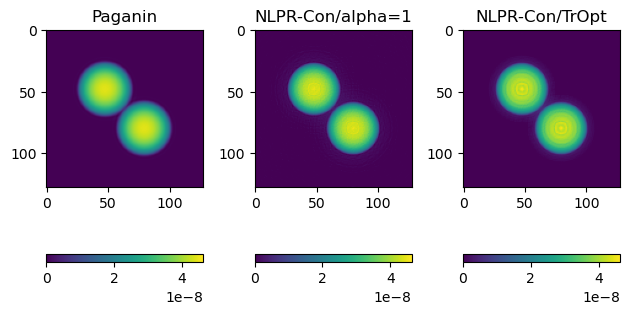

In [19]:
# Use ground-truth to determine the min/max values
vmin, vmax = np.min(delta_projs_gt), np.max(delta_projs_gt)

# Create a matplotlib subplot.
fig, axs = plt.subplots(nrows=1, ncols=3)

# Delta projection image using Paganin phase-retrieval.
im = axs[0].imshow(delta_projs_pag[0], vmin=vmin, vmax=vmax)
axs[0].set_title("Paganin")
fig.colorbar(im, ax=axs[0], orientation="horizontal")

# Delta projection image using constrained NLPR with alpha=1.
im = axs[1].imshow(delta_projs_nlprcon_alpha1[0], vmin=vmin, vmax=vmax)
axs[1].set_title("NLPR-Con/alpha=1")
fig.colorbar(im, ax=axs[1], orientation="horizontal")

# Delta projection image using constrained NLPR with optimized transmission.
im = axs[2].imshow(delta_projs_nlprcon_tropt[0], vmin=vmin, vmax=vmax)
axs[2].set_title("NLPR-Con/TrOpt")
fig.colorbar(im, ax=axs[2], orientation="horizontal")

plt.tight_layout()
plt.show()

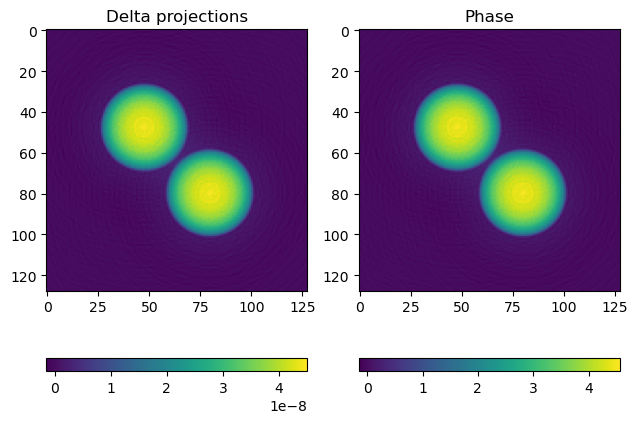

In [20]:
# Use function ``cproj_cphase()`` to convert from delta projections to phase values.
# Use function ``cphase_cproj()`` to convert from phase values to delta projections.
from phasetorch.util import cproj_cphase

phase_nlprcon_alpha1 = cproj_cphase(delta_projs_nlprcon_alpha1, energy=energy)

# Create a matplotlib subplot.
fig, axs = plt.subplots(nrows=1, ncols=2)

# Delta projection image.
im = axs[0].imshow(delta_projs_nlprcon_alpha1[0])
axs[0].set_title("Delta projections")
fig.colorbar(im, ax=axs[0], orientation="horizontal")

# Phase image.
im = axs[1].imshow(phase_nlprcon_alpha1[0])
axs[1].set_title("Phase")
fig.colorbar(im, ax=axs[1], orientation="horizontal")

plt.tight_layout()
plt.show()

Compute the NRMSE between the ground-truth and delta projections from Paganin and NLPR phase-retrieval algorithms.

In [21]:
print("Normalized root mean squared error (NRMSE)")
print("Paganin: ", normalized_root_mse(delta_projs_gt, delta_projs_pag))
print("NLPR-Constrained-alpha=1 | Paganin-Initial: ", normalized_root_mse(delta_projs_gt, delta_projs_nlprcon_alpha1))
print("NLPR-Constrained-TrOpt | Paganin-Initial: ", normalized_root_mse(delta_projs_gt, delta_projs_nlprcon_tropt))

Normalized root mean squared error (NRMSE)
Paganin:  0.10244696209850844
NLPR-Constrained-alpha=1 | Paganin-Initial:  0.056217655042925634
NLPR-Constrained-TrOpt | Paganin-Initial:  0.07434027636604185
